In [76]:
# imports
from torch import nn
import torch
import torch.nn.functional as F

import os
import paths
import numpy as np
import pandas as pd
import importlib
import scipy.io as io
import datetime

import matplotlib.pyplot as plt

In [77]:
# Load the Meyer data
importlib.reload(paths)
# define the file to load
target_file = 'example_freely_moving.npy'

# assemble the full path
load_path = os.path.join(paths.data_path, target_file)

# load the file
data = np.load(load_path)
# load the column names
columns = paths.meyer_columns
# assemble a dataframe
data_df = pd.DataFrame(data, columns=columns)
print(data_df)

        timestamp      pitch       roll   pitch_vel    roll_vel     yaw_vel  \
0        1.102500 -27.272107  20.001065  104.555303  -54.612166  474.530694   
1        1.119167 -26.870819  20.812317   59.359514  -97.330820  421.305060   
2        1.135833 -25.921034  21.914893   42.891156 -106.084538  361.668284   
3        1.152500 -24.963030  23.204492   36.219201 -102.326728  288.762512   
4        1.169167 -24.429489  24.166380    0.696858  -49.549902  219.352208   
...           ...        ...        ...         ...         ...         ...   
36009  601.252500  -5.129397  23.322529  -41.187362   60.579750   10.956741   
36010  601.269167  -4.297887  22.835476  -50.574501   16.956855   -6.383211   
36011  601.285833  -3.479114  22.241257  -30.349570  -21.053428   45.009487   
36012  601.302500  -2.508238  21.701235  -15.561884    4.347795   44.293878   
36013  601.319167  -1.655992  21.405145  -70.995075   36.484132   -8.950008   

       pupil_l_h  pupil_l_v  pupil_r_h  pupil_r_v  

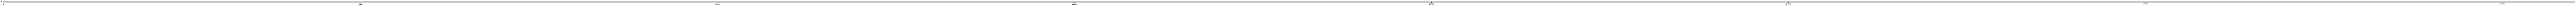

In [34]:
# plot the data

fig = plt.figure(figsize=(300, 10))
ax = fig.add_subplot(111)

# data[np.isnan(data)] = 0
# ax.imshow(data)
ax.imshow(data[:, :].T)
plt.show()

In [39]:
# load the Michaiel data

# Load the Meyer data
importlib.reload(paths)
# define the file to load
target_file = 'Michaiel_et_al.2020_fullDataset.mat'

# assemble the full path
load_path = os.path.join(paths.data_path, target_file)

# load the mat file
data = io.loadmat(load_path)

print(data.keys())
print(data['allRoll'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'accelerometerChs', 'accelerometerChsRaw', 'allAppT', 'allAvgPhi', 'allGyroYaw', 'allRoll', 'allTilt', 'allYaw', 'animalName', 'approachEpochs', 'azimuth', 'clipNumber', 'cricketTheta', 'cricket_xy', 'crickeyVel', 'dPhiL', 'dTheta', 'dThetaL', 'dVergence', 'd_allAvgPhi', 'd_headThDLC', 'dist2cricket', 'dphiR', 'dthetaR', 'expDate', 'expSession', 'eyeScaleL', 'eyeScaleR', 'eyeSlopeL', 'eyeSlopeR', 'eyefitParamsL', 'eyefitParamsR', 'headThDLC', 'headTheta', 'mouseVel', 'mouse_xy', 'phiL', 'phiR', 'thetaL', 'thetaR', 'vergence'])
(1, 377459)


In [41]:
# define the architecture
class Neural_Net(nn.Module):

    def __init__(self):
        super(Neural_Net, self).__init__()
        self.fc1 = nn.Linear(2,10)
        self.fc2 = nn.Linear(10,4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [102]:
# Instantiate and define loss, optimizer, epochs
model = Neural_Net()
cost_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
epochs = 10000

In [103]:
# preprocess the data
nonan_data = data_df.copy()
nonan_data = nonan_data.loc[~np.any(np.isnan(nonan_data), axis=1)]

nonan_data = (nonan_data-nonan_data.min())/(nonan_data.max()-nonan_data.min())

# print(nonan_data)


tensor_head = torch.tensor(nonan_data.loc[:, ['pitch', 'roll']].to_numpy()).float()
tensor_eyes = torch.tensor(nonan_data.loc[:, ['pupil_l_h', 'pupil_l_v', 'pupil_r_h', 'pupil_r_v']].to_numpy()).float()



print(tensor_head.shape)

torch.Size([31086, 2])


In [104]:
# Train the network
for i in range(epochs):
    output = model(tensor_head)
    loss = cost_func(output, tensor_eyes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i % 1000 == 0):
        print(loss)

tensor(0.1826, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0092, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)


In [105]:
# Export the model

# assemble the export path
export_name = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S") + '_eyemodel.onnx'
export_path = os.path.join(paths.model_path, export_name)

torch.onnx.export(model,                              # model being run
                  tensor_head[0],                       # model dummy input (or a tuple for multiple inputs)
                  export_path,                  # where to save the model (can be a file or file-like object)
                  export_params=True,                 # store the trained parameter weights inside the model file
                  opset_version=9,                    # the ONNX version to export the model to
                  do_constant_folding=True,           # whether to execute constant folding for optimization
                  input_names=['head_angles'],                # the model's input names
                  output_names=['eye_position']                # the model's output names
                  )